<a href="https://colab.research.google.com/github/ElenaSelishcheva/ML_course_7_semester/blob/main/Homewprk_%E2%84%965.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the FashionMNIST dataset...
Generating the train/test split...
Initializing the model...
Training the network...
Epoch 1/10
Train loss: 0.086119, Train accuracy: 0.9703
Val loss: 0.036239, Val accuracy: 0.9857

Epoch 2/10
Train loss: 0.027218, Train accuracy: 0.9911
Val loss: 0.027908, Val accuracy: 0.9883

Epoch 3/10
Train loss: 0.022385, Train accuracy: 0.9926
Val loss: 0.053648, Val accuracy: 0.9847

Epoch 4/10
Train loss: 0.020039, Train accuracy: 0.9927
Val loss: 0.025665, Val accuracy: 0.9920

Epoch 5/10
Train loss: 0.014918, Train accuracy: 0.9944
Val loss: 0.021916, Val accuracy: 0.9917

Epoch 6/10
Train loss: 0.011316, Train accuracy: 0.9962
Val loss: 0.025102, Val accuracy: 0.9940

Epoch 7/10
Train loss: 0.011268, Train accuracy: 0.9962
Val loss: 0.025424, Val accuracy: 0.9940

Epoch 8/10
Train loss: 0.007983, Train accuracy: 0.9969
Val loss: 0.031320, Val accuracy: 0.9917

Epoch 9/10
Train loss: 0.008299, Train accuracy: 0.9969
Val loss: 0.016939, Val accuracy: 0.993

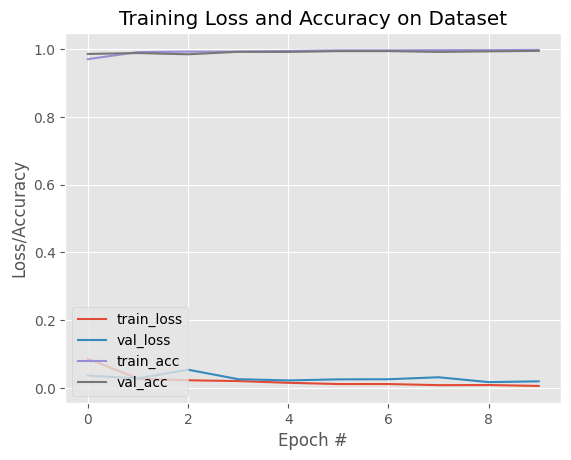

In [ ]:
# Свёрточная сеть на Pytorch для классификации изображений

# Мои данные: FashionMNIST: https://github.com/zalandoresearch/fashion-mnist

# Моя архитектура: Число свёрточных слоёв — 2, размер окна пулинга — 2 × 2

from torch import flatten
from torch.nn import (Module, Conv2d, Linear, MaxPool2d,
                      ReLU, LogSoftmax)
from sklearn.metrics import classification_report
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

# класс классификатора, реализующий свёрточную сеть
class ConvNet(Module):
    def __init__(self, num_channels, num_classes):
        Module.__init__(self)
        # создаём переменные для числа скрытых нейронов
        layer1_num = 30
        layer2_num = 50
        layer3_num = 200
        # создаём первый свёрточный слой из двумерной свёртки
        # Conv2d, нелинейного преобразования ReLU и пулинга MaxPool
        self.conv1 = Conv2d(in_channels=num_channels,
                      out_channels=layer1_num,
                      kernel_size=(2, 2))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # второй слой той же структуры, но с другим количеством признаков
        self.conv2 = Conv2d(in_channels=layer1_num,
                      out_channels=layer2_num,
                      kernel_size=(2, 2))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # теперь нужен классификатор - обычный многослойный персептрон.
        # Число его входов зависит от размерности входных данных.
        # Первый полносвязный слой (и его нелинейное преобразование):
        self.fc1 = Linear(in_features=1800, out_features=layer3_num)
        self.relu3 = ReLU()
        # второй полносвязный слой
        self.fc2 = Linear(in_features=layer3_num, out_features=num_classes)
        # softmax для масштабирования выхода
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        # подадим входные данные x на слои:
        # первый свёрточный слой
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # второй свёрточный слой
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # превратим входные данные в вектор:
        x = flatten(x, 1)
        # подадим вектор на первый полносвязный слой
        x = self.fc1(x)
        x = self.relu3(x)
        # и на второй, с расчётом вероятностей
        x = self.fc2(x)
        output = self.logSoftmax(x)
        # выдадим предсказания о принадлежности к классам
        return output

# Гиперпараметры для обучения:
INIT_LR = 1e-3

BATCH_SIZE = 64

EPOCHS = 10

TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading the FashionMNIST dataset...")

selected_classes = [0, 1]

full_dataset = FashionMNIST(root="data", train=True, download=True,
    transform=ToTensor())
# индексы образцов, которые принадлежат выбранным классам
filtered_indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] in selected_classes]

trainData = Subset(full_dataset, filtered_indices)

# загружаем тестовую выборку
testData = FashionMNIST(root="data", train=False, download=True,
    transform=ToTensor())

filtered_test_indices = [i for i in range(len(testData)) if testData.targets[i] in selected_classes]

testData = Subset(testData, filtered_test_indices)

print("Generating the train/test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)

(trainData, valData) = random_split(trainData,
    [numTrainSamples, numValSamples],
    generator=torch.Generator().manual_seed(17))

# Создаём объекты-загрузчики данных (класс DataLoader):
trainDataLoader = DataLoader(trainData, shuffle=True,
    batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# вычислим число шагов в эпохе обучения
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


# инициализируем класс нейросети
print("Initializing the model...")
model = ConvNet(
    num_channels=1,
    num_classes=len(selected_classes)).to(device)
# используем алгоритм оптимизации сети Adam
opt = Adam(model.parameters(), lr=INIT_LR)
# функция ошибок
lossFn = nn.NLLLoss()

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

print("Training the network...")
startTime = time.time()

# для каждой эпохи
for e in range(0, EPOCHS):
    # переключить сеть в режим обучения
    model.train()
    # обнуляем счётчики ошибок обучающей и валидационной выборки
    totalTrainLoss = 0
    totalValLoss = 0
    # обнуляем счётчики правильных ответов
    trainCorrect = 0
    valCorrect = 0
    # для каждого примера в обучающей выборке
    for (x, y) in trainDataLoader:
        # передаём входные данные и правильный ответ на устройство
        (x, y) = (x.to(device), y.to(device))
        # рассчитываем выходы по переданным входным данным
        pred = model(x)
        # рассчитываем ошибку полученных выходов
        loss = lossFn(pred, y)
        # обнуляем градиенты в оптимизаторе
        opt.zero_grad()
        # выполняем обратное распространение ошибки
        loss.backward()
        # обновляем веса используемым оптимизатором
        opt.step()
        # добавляем полученную ошибку к суммарной
        totalTrainLoss += loss
        # обновляем число правильных ответов
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
    # Полный проход обучающей выборки закончен.
    # Отключаем автоматический расчёт градиентов (он нужен
    # только для обучения)
    with torch.no_grad():
        # переключаем модель в рабочий режим
        model.eval()
        # для каждого куска валидационной выборки
        for (x, y) in valDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
    # Прохождение обучающей и валидационной частей выборки закончено.
    # Вычислим среднюю ошибку
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # вычисляем точность
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)
    # добавляем данные в историю обучения
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    print("Epoch {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
        avgValLoss, valCorrect))

endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# Подаём на полностью обученную сеть тестовую выборку,
print("Evaluating network...")
# опять отключаем вычисление градиентов
with torch.no_grad():
    # опять переводим модель в рабочий режим
    model.eval()
    # список для ответов сети
    preds = []
    for (x, y) in testDataLoader:
        x = x.to(device)
        pred = model(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

# отчёт о классификации
indices = testData.indices
targets = testData.dataset.targets[indices]
print(classification_report(targets.numpy(),
                            np.array(preds),
                            target_names=[str(i) for i in selected_classes]))


plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("test_res.png")
# сохранить обученную модель в файле
torch.save(model, "result_model.bin")
